In [53]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
!pip install lightgbm

^C
ERROR: Operation cancelled by user


In [54]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [55]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

# removing unused columns
train_data.drop(['url_legal', 'license','standard_error'], axis=1, inplace=True)
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)


from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=20)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15,random_state=20)

In [56]:
x_td=test_data['excerpt']

In [57]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 150

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("../input/tf-bert-model", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [58]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [59]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [60]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [61]:
import sys
#print(sys.path)
sys.path.append('../input/tokenization')
import tokenization

#import tokenization
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [62]:

from tqdm import tqdm
X_train_tokens=[]
X_train_mask=[]
X_train_segment=[]
max_len_limit=max_seq_length-2
N=0
for i in tqdm(range(len(x_train.values))):
  tokens=tokenizer.tokenize(x_train.values[i])
  if len(tokens)>max_len_limit or len(tokens)==max_len_limit:
    tokens=tokens[0:max_seq_length-2]
    tokens=['[CLS]',*tokens,'[SEP]']
    X_train_mask.append(np.array([1]*len(tokens)))
  if len(tokens)<max_len_limit:
    X_train_mask.append(np.array([1]*(len(tokens)+2)+[0]*(max_seq_length-len(tokens)-2)))
    for i in range(max_seq_length-len(tokens)-2):
      N=N+1
      tokens.append('[PAD]')
    tokens=['[CLS]',*tokens,'[SEP]']
  X_train_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
  X_train_segment.append(np.array([0]*max_seq_length))

100%|██████████| 2046/2046 [00:08<00:00, 249.67it/s]


In [63]:
X_test_tokens=[]
X_test_mask=[]
X_test_segment=[]
N=0
for i in tqdm(range(len(x_test.values))):
  tokens=tokenizer.tokenize(x_test.values[i])
  if len(tokens)>max_len_limit or len(tokens)==max_len_limit:
    tokens=tokens[0:max_seq_length-2]
    tokens=['[CLS]',*tokens,'[SEP]']
    X_test_mask.append(np.array([1]*len(tokens)))
  if len(tokens)<max_len_limit:
    X_test_mask.append(np.array([1]*(len(tokens)+2)+[0]*(max_seq_length-len(tokens)-2)))
    for i in range(max_seq_length-len(tokens)-2):
      N=N+1
      tokens.append('[PAD]')
    tokens=['[CLS]',*tokens,'[SEP]']
  X_test_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
  X_test_segment.append(np.array([0]*max_seq_length))

100%|██████████| 426/426 [00:01<00:00, 219.52it/s]


In [64]:
X_cv_tokens=[]
X_cv_mask=[]
X_cv_segment=[]
N=0
for i in tqdm(range(len(x_cv.values))):
  tokens=tokenizer.tokenize(x_cv.values[i])
  if len(tokens)>max_len_limit or len(tokens)==max_len_limit:
    tokens=tokens[0:max_seq_length-2]
    tokens=['[CLS]',*tokens,'[SEP]']
    X_cv_mask.append(np.array([1]*len(tokens)))
  if len(tokens)<max_len_limit:
    X_cv_mask.append(np.array([1]*(len(tokens)+2)+[0]*(max_seq_length-len(tokens)-2)))
    for i in range(max_seq_length-len(tokens)-2):
      N=N+1
      tokens.append('[PAD]')
    tokens=['[CLS]',*tokens,'[SEP]']
  X_cv_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
  X_cv_segment.append(np.array([0]*max_seq_length))

100%|██████████| 362/362 [00:01<00:00, 245.15it/s]


In [65]:
X_td_tokens=[]
X_td_mask=[]
X_td_segment=[]
N=0
for i in tqdm(range(len(x_td.values))):
  tokens=tokenizer.tokenize(x_td.values[i])
  if len(tokens)>max_len_limit or len(tokens)==max_len_limit:
    tokens=tokens[0:max_seq_length-2]
    tokens=['[CLS]',*tokens,'[SEP]']
    X_td_mask.append(np.array([1]*len(tokens)))
  if len(tokens)<max_len_limit:
    X_td_mask.append(np.array([1]*(len(tokens)+2)+[0]*(max_seq_length-len(tokens)-2)))
    for i in range(max_seq_length-len(tokens)-2):
      N=N+1
      tokens.append('[PAD]')
    tokens=['[CLS]',*tokens,'[SEP]']
  X_td_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
  X_td_segment.append(np.array([0]*max_seq_length))

100%|██████████| 7/7 [00:00<00:00, 216.45it/s]


In [66]:
X_train_tokens=np.asarray(X_train_tokens)
X_train_mask=np.asarray(X_train_mask)
X_train_segment=np.asarray(X_train_segment)

X_test_tokens=np.asarray(X_test_tokens)
X_test_mask=np.asarray(X_test_mask)
X_test_segment=np.asarray(X_test_segment)

X_cv_tokens=np.asarray(X_cv_tokens)
X_cv_mask=np.asarray(X_cv_mask)
X_cv_segment=np.asarray(X_cv_segment)

X_td_tokens=np.asarray(X_td_tokens)
X_td_mask=np.asarray(X_td_mask)
X_td_segment=np.asarray(X_td_segment)


In [67]:
X_train_pooled_output=bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])
X_cv_pooled_output=bert_model.predict([X_cv_tokens, X_cv_mask, X_cv_segment])
X_td_pooled_output=bert_model.predict([X_td_tokens, X_td_mask, X_td_segment])


In [68]:
 ##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

#Input layer
input_layer = Input(shape=(768,))
#Dense hidden layer
layer1 = Dense(256,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(input_layer)
Dropout_layer_1=Dropout(0.2)(layer1)
#Dense hidden layer
layer2 = Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(Dropout_layer_1)
Dropout_layer_2=Dropout(0.2)(layer2)
#Dense hidden layer
layer3 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(Dropout_layer_2)
#output layer
output = Dense(1,activation='linear',kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(layer3)
#Creating a model
Model = Model(inputs=input_layer,outputs=output)

Model.compile(optimizer='adam', loss='MeanSquaredError',metrics=['MeanSquaredError'])

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True,write_grads=True)
Model.fit(X_train_pooled_output,y_train,epochs=100, validation_data=(X_cv_pooled_output,y_cv), batch_size=10,callbacks=[early_stop_1])

Epoch 1/100
205/205 [==============================] - 1s 3ms/step - loss: 1.1690 - mean_squared_error: 1.1690 - val_loss: 0.9221 - val_mean_squared_error: 0.9221
Epoch 2/100
205/205 [==============================] - 1s 2ms/step - loss: 0.6770 - mean_squared_error: 0.6770 - val_loss: 0.6285 - val_mean_squared_error: 0.6285
Epoch 3/100
205/205 [==============================] - 1s 3ms/step - loss: 0.6245 - mean_squared_error: 0.6245 - val_loss: 0.5548 - val_mean_squared_error: 0.5548
Epoch 4/100
205/205 [==============================] - 1s 3ms/step - loss: 0.5603 - mean_squared_error: 0.5603 - val_loss: 0.5584 - val_mean_squared_error: 0.5584
Epoch 5/100
205/205 [==============================] - 1s 2ms/step - loss: 0.5582 - mean_squared_error: 0.5582 - val_loss: 0.5857 - val_mean_squared_error: 0.5857
Epoch 6/100
205/205 [==============================] - 1s 2ms/step - loss: 0.5359 - mean_squared_error: 0.5359 - val_loss: 0.5289 - val_mean_squared_error: 0.5289
Epoch 7/100
205/205 [=

In [69]:
y_pred_test=Model.predict(X_test_pooled_output)
mean_squared_error(y_pred_test,y_test)

0.4206100150490887

#Predicting Test data

In [70]:
y_pred_td=Model.predict(X_td_pooled_output)

In [71]:
y_pred_td

array([[-0.628463  ],
       [ 0.28208944],
       [-1.0595914 ],
       [-1.3554636 ],
       [-0.8734646 ],
       [-0.7647553 ],
       [ 0.32074523]], dtype=float32)

In [72]:
test_dat = pd.read_csv('../input/commonlitreadabilityprize/test.csv',index_col='id')
y_pred_pd=pd.DataFrame(y_pred_td,index=test_dat.index,columns=['target'])
#y_pred_pd

#saving test data predicted
y_pred_pd.to_csv('./submission.csv')

#LeaderBoard

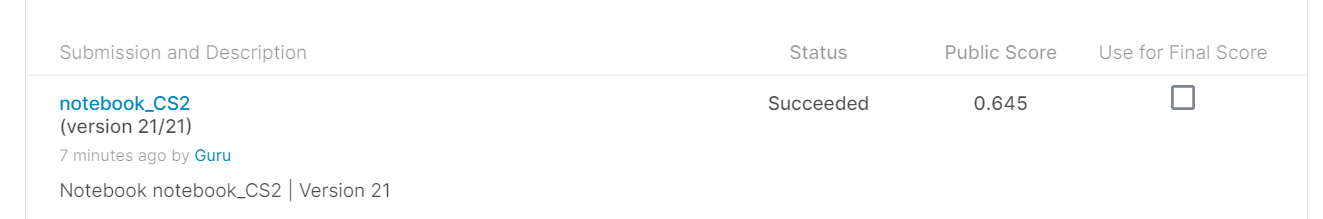